In [9]:
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction

from qiskit import QuantumCircuit, Aer, execute, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import DraperQFTAdder as draper

In [13]:
# functions

# Draper QFT adder, in gate form
# https://arxiv.org/pdf/quant-ph/0008033.pdf
def add(qc, a, b, n):
    drapergate = draper(n,kind = "half").decompose().decompose().to_gate()
    qc.append(drapergate,list(a[:]) + list(b[:]))

#a,b -> a,b+a or a,b-a
def makeAdder(nbits,adding = True):
    qc = QuantumCircuit(2*nbits+1) #a is size N, b is N + 1
    add(qc, range(nbits), range(nbits,2*nbits+1),nbits)
    addergate = qc.to_gate()
    addergate.name = "adder"
    iaddergate = addergate.inverse()
    iaddergate.name = "inverse adder"
    if adding:
        return addergate
    else:
        return iaddergate

def binary(num,length):
    b = bin(num)[2:]
    return "0"*(length-len(b))+str(b)

def x(number,length,controls = 0): #this changes a decimal number to a series of x gates, not to be confused with qc.x 
    circ = QuantumCircuit(length)
    for i,num in enumerate(binary(number,length)):
        if num == "1":
            circ.x(length - 1 - i)
        xgate = circ.to_gate()
        xgate.name = str(number)
    if controls != 0:
        cxgate = xgate.control(controls)
        return cxgate #num bitts will be controls + length
    else:
        return xgate

def makeAdderMod(a,b,t1,t2,n,nbits,N,control = False): #a,b,n quantum registers, output a,a+bmodN, N. t and aux both start and end zero
    qc = QuantumCircuit(a, b, t1, t2, n)
    qc.append(makeAdder(nbits,True),range(2*nbits+1))
    qc.swap(a,n)
    qc.append(makeAdder(nbits, False),range(2*nbits+1))
    qc.x(t1)
    qc.cx(t1,t2)
    qc.x(t1)
    #set top register to zero by bitwise adding N
    qc.append(x(N,nbits,1),t2[:] + a[:])
    qc.append(makeAdder(nbits,True),range(2*nbits+1)) #adds nothing if b is already positive
    #turn it back into N
    qc.append(x(N,nbits,1),t2[:] + a[:])
    qc.swap(a,n)
    qc.append(makeAdder(nbits, False),range(2*nbits+1))
    qc.cx(t1,t2) #t2 reset to zero
    qc.append(makeAdder(nbits, True),range(2*nbits+1))
    addmod = qc.to_gate()
    addmod.name = "a + b mod "+str(N)
    
    if control:
        caddmod = addmod.control(1)
        return caddmod
    else:
        return addmod
    
def makecmult(c, xreg, tempa, y, t1, t2, n, numa, nbits, N,inv = False):
    qc = QuantumCircuit(c,xreg,tempa,y,t1,t2,n)
    for p in range(nbits):
        qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
        qc.append(makeAdderMod(tempa,y,t1,t2,n,nbits,N),tempa[:] + y[:] + t1[:] + t2[:] + n[:])
        qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
    qc.x(c)
    for q in range(nbits):
        qc.ccx(c,xreg[q],y[q])
    qc.x(c)
    cmult = qc.to_gate()
    iqc = qc.inverse()
    icmult = iqc.to_gate()
    cmult.name = "times "+str(numa)+" mod "+str(N)
    icmult.name = "inverse of (times "+str(numa)+" mod "+str(N)+")"
    return icmult if inv else cmult

def fakecmult(c, xreg, tempa, y, t1, t2, n, numa, nbits, N,inv = False):
    qc = QuantumCircuit(c,xreg,tempa,y,t1,t2,n)
    cmult = qc.to_gate()
    iqc = qc.inverse()
    icmult = iqc.to_gate()
    cmult.name = "times "+str(numa)+" mod "+str(N)
    icmult.name = "divided by "+str(modinv(numa,N))+" mod "+str(N)
    return icmult if inv else cmult

def makea2pmod(out1, tempa, out2, t1, t2, n, numa,p,nbits,N):
    c = QuantumRegister(1)
    qc = QuantumCircuit(c, out1, tempa, out2, t1, t2, n)
    #print(l,(numa**(2**l))%N) #it's the iversion that's wrong
    qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, (numa**(2**p))%N, nbits, N),list(range(0,4*nbits+3)))
    qc.swap(out1,out2)
    qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, modinv((numa**(2**p))%N,N), nbits, N, True),list(range(0,4*nbits+3)))
    #qc = qc.to_gate()
    qc.name = str(numa)+"^"+str(2**p)+" mod "+str(N)
    return qc



def makeAXmod(xreg, out1, tempa, out2, t1, t2, n,numa,mbits,nbits,N,control = False):
    qc = QuantumCircuit(xreg, out1, tempa, out2, t1, t2, n)
    #x starts and finishes as NOT ZERO
    c = QuantumRegister(1)
    for l in range(mbits):
        #print(l,(numa**(2**l))%N) #it's the iversion that's wrong
        qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, (numa**(2**l))%N, nbits, N),[l] + list(range(mbits,mbits+(4*nbits+2))))
        qc.swap(out1,out2)
        qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, modinv((numa**(2**l))%N,N), nbits, N, True),[l] + list(range(mbits,mbits+(4*nbits+2))))
    #qc.append(x(numx,mbits),xreg[:]) #reset x to zero
    if control:
        qc = qc.control(1)
    AXmod = qc#.to_gate()
    AXmod.name = str(numa)+"^x mod "+str(N)        
    return AXmod

#Euclidean gcd method source: Wikibooks
#https://en.wikibooks.org/wiki/Algorithm_Implementation/Mathematics/Extended_Euclidean_algorithm
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)
def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

#source: Qiskit textbook
def QFT(n):
    circuit = QuantumCircuit(n)
    for bit in range(n//2):
        circuit.swap(bit,n-bit-1)
    for j in range(n):
        for m in range(j):
            circuit.cp(np.pi/(2**(j-m)), m, j) 
        circuit.h(j)
    circuit.name = "QFT"
    return circuit

def makeSum(inverse = False):
    qc = QuantumCircuit(3)
    qc.cx(1,2)
    qc.cx(0,2)
    return qc.inverse() if inverse else qc

def carry(inverse = False):
    qc = QuantumCircuit(4)
    qc.ccx(1,2,3)
    qc.cx(1,2)
    qc.ccx(0,2,3)
    return qc.inverse() if inverse else qc
    
def sim(qc): #prints simulated results of 2 classical registers
    backend_sim = Aer.get_backend('aer_simulator')
    job_sim = execute(qc, backend_sim,shots = 100)
    result_sim = job_sim.result()
    results = str(list(result_sim.get_counts().keys())[0]).split(" ") #result of add is b+a a
    resultsint = [int(res,2) for res in results]
    print(resultsint[1],resultsint[0])

# test code to make sure the adder gate works
A = 5
B = 7
ca,cb = ClassicalRegister(4),ClassicalRegister(5)
q = QuantumRegister(9)
qc = QuantumCircuit(q,ca,cb)
qc.append(x(A,4),range(4))
qc.append(x(B,4),range(4,8))
qc.append(makeAdder(4,True),range(9))
qc.barrier()
qc.measure(range(4),ca)
qc.measure(range(4,9),cb)
sim(qc)
print(A,A+B)
qc.draw(output="text",plot_barriers=False,fold = -1)

5 12
5 12


┌────┐┌────────┐ ┌─┐                        
q70_0: ┤0   ├┤0       ├─┤M├────────────────────────
       │    ││        │ └╥┘┌─┐                     
q70_1: ┤1   ├┤1       ├──╫─┤M├─────────────────────
       │  5 ││        │  ║ └╥┘┌─┐                  
q70_2: ┤2   ├┤2       ├──╫──╫─┤M├──────────────────
       │    ││        │  ║  ║ └╥┘┌─┐               
q70_3: ┤3   ├┤3       ├──╫──╫──╫─┤M├───────────────
       ├────┤│        │  ║  ║  ║ └╥┘┌─┐            
q70_4: ┤0   ├┤4 adder ├──╫──╫──╫──╫─┤M├────────────
       │    ││        │  ║  ║  ║  ║ └╥┘┌─┐         
q70_5: ┤1   ├┤5       ├──╫──╫──╫──╫──╫─┤M├─────────
       │  7 ││        │  ║  ║  ║  ║  ║ └╥┘┌─┐      
q70_6: ┤2   ├┤6       ├──╫──╫──╫──╫──╫──╫─┤M├──────
       │    ││        │  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
q70_7: ┤3   ├┤7       ├──╫──╫──╫──╫──╫──╫──╫─┤M├───
       └────┘│        │  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q70_8: ──────┤8       ├──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
             └────────┘  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
 c4: 4/══════════════════╩══╩══╩══╩══╬══╬══╬══╬══╬═
                         0  1  2  3  ║  ║  ║  ║  ║ 
                                     ║  ║  ║  ║  ║ 
 c5: 5/══════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4

15 27
15 27


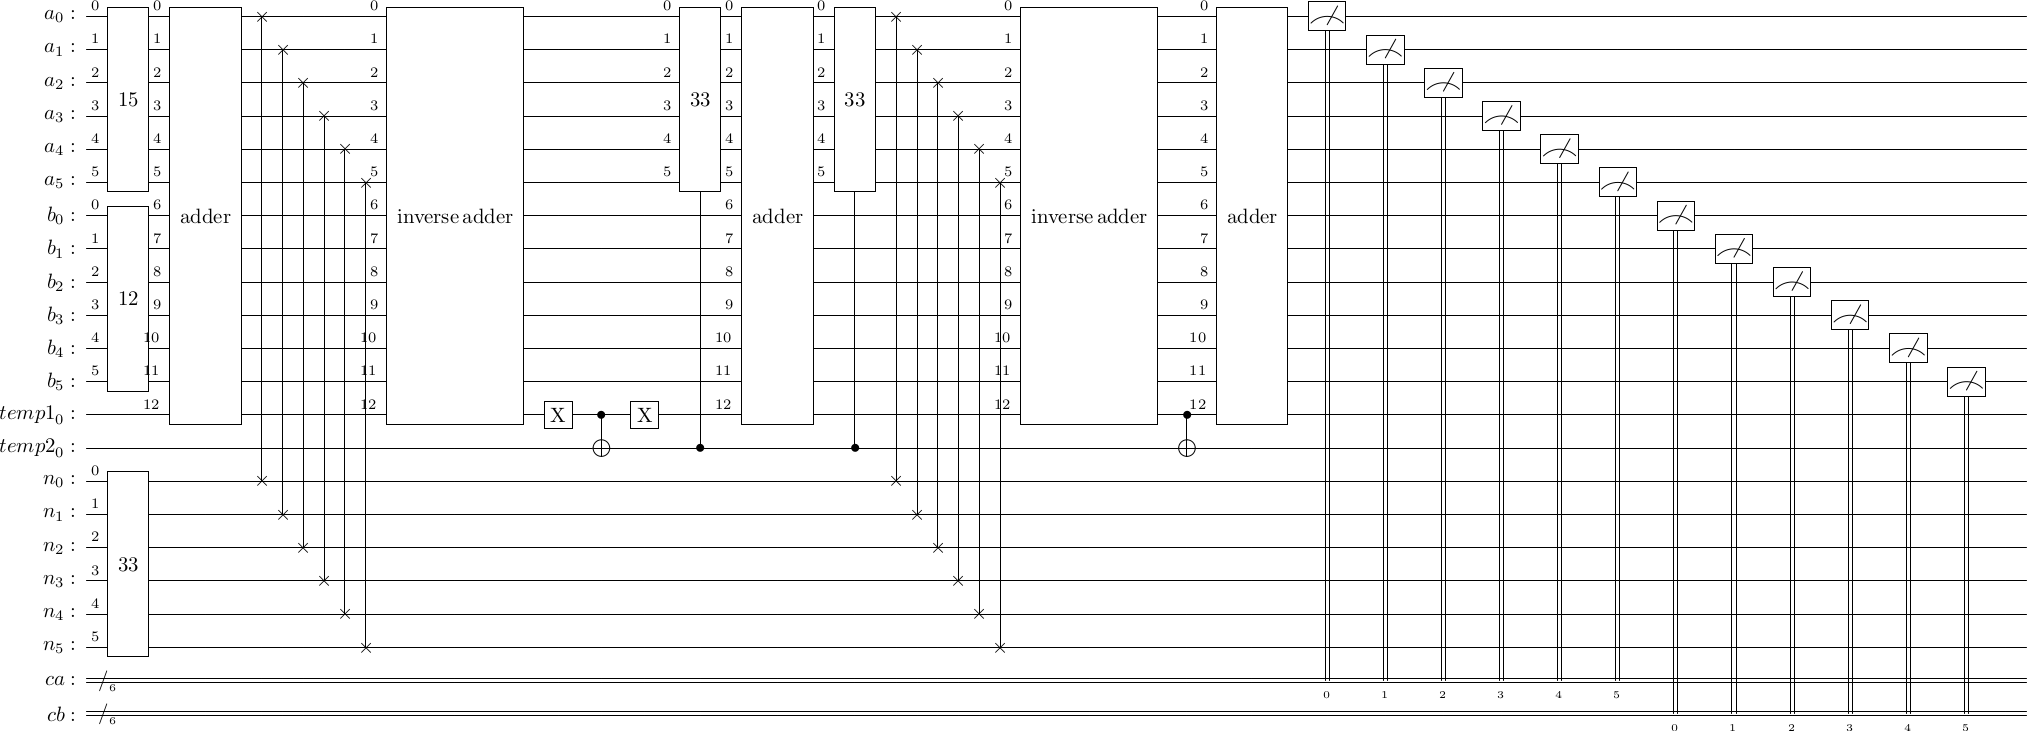

In [14]:
#modular addition
N = 33
numa = 15
numb = 12  #works as long as a+b < 2N
nbits = 6

a = QuantumRegister(nbits,"a")
b = QuantumRegister(nbits,"b")
t1 = QuantumRegister(1,"temp1")
n = QuantumRegister(nbits,"n")
t2 = QuantumRegister(1,"temp2")
ca = ClassicalRegister(nbits,"ca")
cb = ClassicalRegister(nbits,"cb")

qc = QuantumCircuit(a, b, t1, t2, n, ca, cb)

#initialise qubits
qc.append(x(numa,nbits),a[:])
qc.append(x(numb,nbits),b)
qc.append(x(N,nbits),n)

#draw the circuit    
qc.append(makeAdder(nbits,True),range(2*nbits+1))
qc.swap(a,n)
qc.append(makeAdder(nbits, False),range(2*nbits+1))
qc.x(t1)
qc.cx(t1,t2)
qc.x(t1)
#set top register to zero by bitwise adding N
qc.append(x(N,nbits,1),t2[:] + a[:])
qc.append(makeAdder(nbits,True),range(2*nbits+1))

#turn it back into N
qc.append(x(N,nbits,1),t2[:] + a[:])
qc.swap(a,n)
qc.append(makeAdder(nbits, False),range(2*nbits+1))
qc.cx(t1,t2) #t2 reset to zero
qc.append(makeAdder(nbits, True),range(2*nbits+1))


qc.measure(a,ca)
qc.measure(b,cb)
sim(qc)
print(numa,(numa+numb)%N) #check against correct value
qc.draw(output = "latex",fold = -1,plot_barriers = False)
#result is a, a+b mod N

6 0
6 0


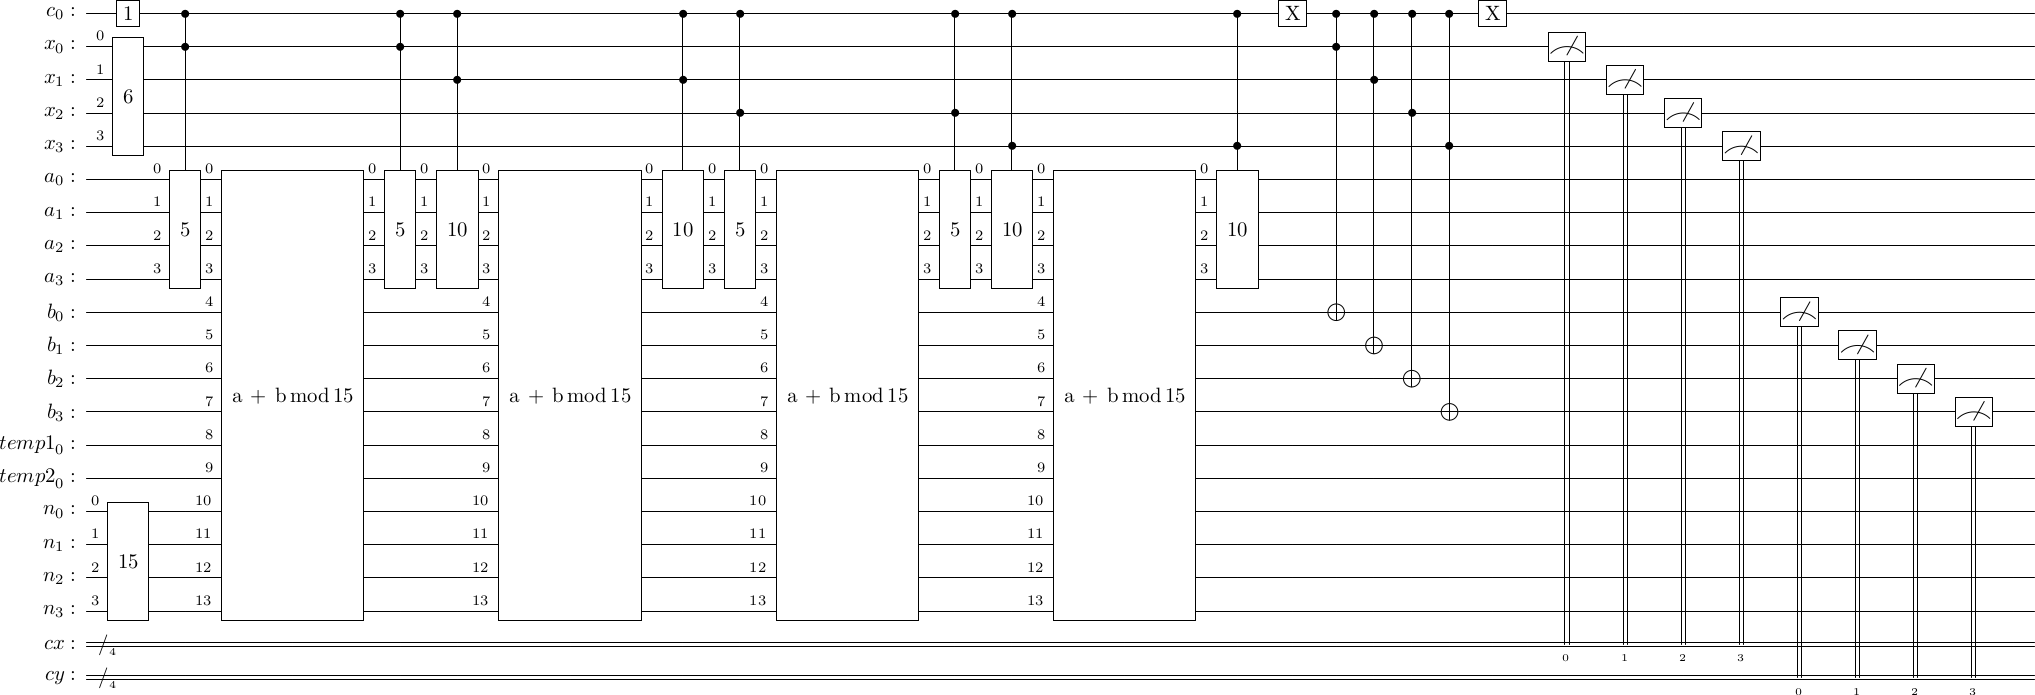

In [15]:
#controlled mult
N = 15
numx = 6
numa = 5
nbits = 4 #goal = c,x,0 -> c,x,ax mod N
on = True

c = QuantumRegister(1,"c")         #control for next step
xreg = QuantumRegister(nbits,"x")  #output 1
tempa = QuantumRegister(nbits,"a") #temp from adder (nbits)
y = QuantumRegister(nbits,"b")     #output 2
t1 = QuantumRegister(1,"temp1")    #temp from adder (1)
t2 = QuantumRegister(1,"temp2")    #temp from adder (1)
n = QuantumRegister(nbits,"n")     #N               (nbits)
cx = ClassicalRegister(nbits,"cx") #answer
cy = ClassicalRegister(nbits,"cy") #answer

qc = QuantumCircuit(c, xreg, tempa, y, t1, t2, n, cx, cy)
#initialise qubits
qc.append(x(numx,nbits),xreg)
qc.append(x(N,nbits),n)
if on:
    qc.append(x(1,1),c)
    
for p in range(nbits):
    qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
    qc.append(makeAdderMod(tempa,y,t1,t2,n,nbits,N),tempa[:] + y[:] + t1[:] + t2[:] + n[:])
    qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
qc.x(c)
for q in range(nbits):
    qc.ccx(c,xreg[q],y[q])
qc.x(c)


qc.barrier()
qc.measure(xreg,cx)
qc.measure(y,cy)
sim(qc)
print(numx,(numa*numx)%N)
qc.draw(output= "latex",fold = -1,plot_barriers=False)

4 0
4 0


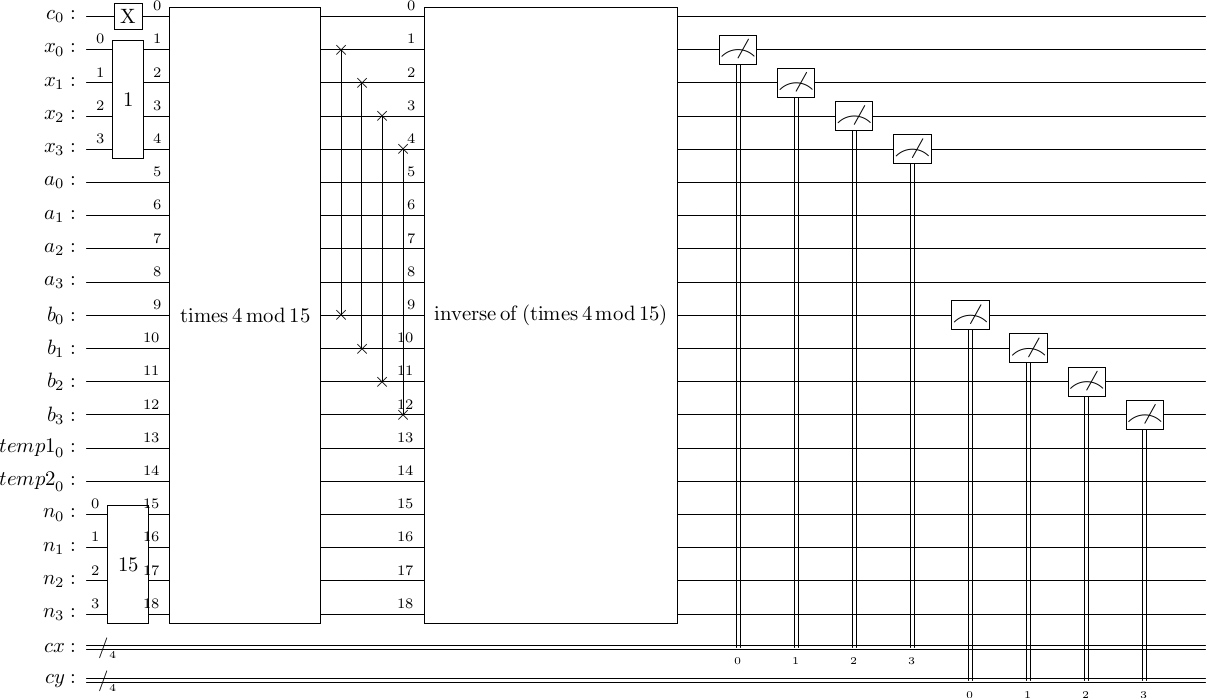

In [6]:
N = 15
numa = 2
nbits = 4
p = 1 #power of 2
#result = a^2^p mod n


#xreg = QuantumRegister(mbits,"x")     #control, max x is 2^nbits for now but we can define mbits instead
c = QuantumRegister(1,"c")
out1 = QuantumRegister(nbits,"x")      #output 1
tempa = QuantumRegister(nbits,"a")     #temp from adder (nbits)
out2 = QuantumRegister(nbits,"b")      #temp from cmult
t1 = QuantumRegister(1,"temp1")        #temp from adder (1)
t2 = QuantumRegister(1,"temp2")        #temp from adder (1)
n = QuantumRegister(nbits,"n")         #N               (nbits)
cx = ClassicalRegister(nbits,"cx")     #answer (same size as xreg)
cy = ClassicalRegister(nbits,"cy")     #answer 

qc = QuantumCircuit(c, out1, tempa, out2, t1, t2, n, cx, cy)

qc.x(c)
qc.append(x(1,nbits),out1)
qc.append(x(N,nbits),n)

qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, (numa**(2**p))%N, nbits, N),list(range(0,4*nbits+3)))
qc.swap(out1,out2)
qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, modinv((numa**(2**p))%N,N), nbits, N, True),list(range(0,4*nbits+3)))              
    
qc.barrier()
qc.measure(out1,cx)
qc.measure(out2,cy)

sim(qc)
print((numa**(2**p)) % N,0)
qc.draw(output= "latex",fold = -1,plot_barriers=False)

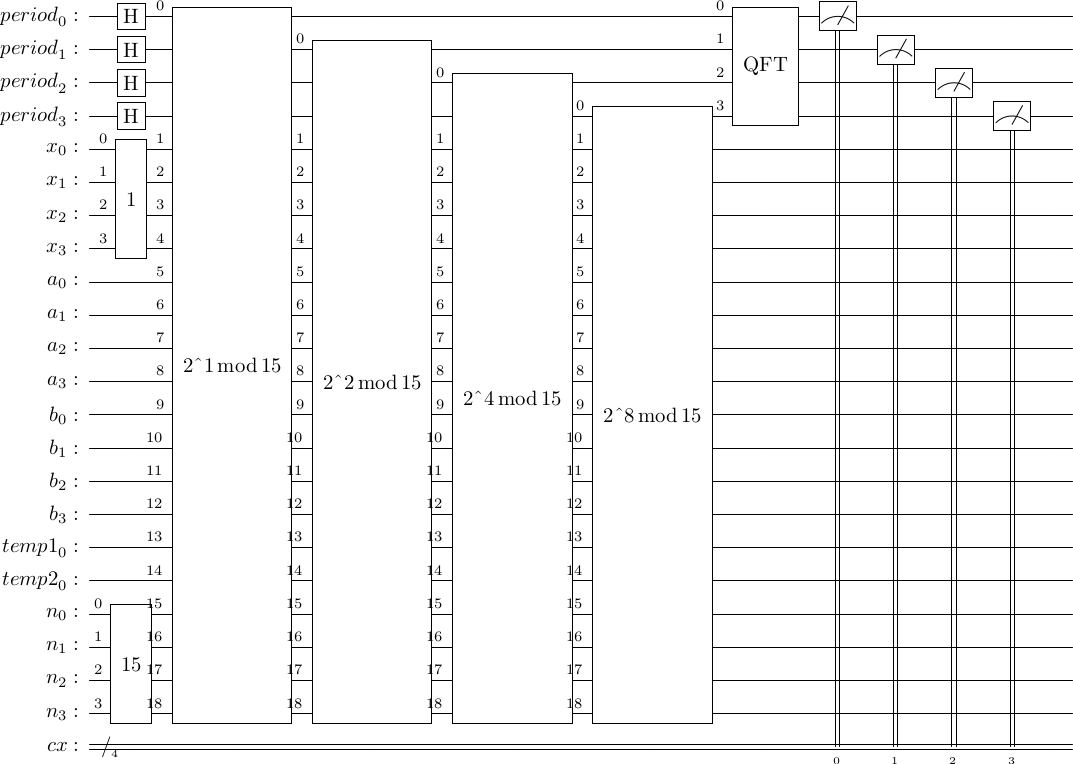

In [3]:
N = 15
numa = 2
nbits = 4
mbits = nbits

period = QuantumRegister(mbits,"period")
out1 = QuantumRegister(nbits,"x")     #output 1
tempa = QuantumRegister(nbits,"a")    #temp from adder (nbits)
out2 = QuantumRegister(nbits,"b")     #temp from cmult
t1 = QuantumRegister(1,"temp1")       #temp from adder (1)
t2 = QuantumRegister(1,"temp2")       #temp from adder (1)
n = QuantumRegister(nbits,"n")        #N               (nbits)
cx = ClassicalRegister(mbits,"cx")    #answer (same size as xreg)


qc = QuantumCircuit(period, out1, tempa, out2, t1, t2, n, cx)
#qc.append(x(14,mbits),period[:])
qc.h(period[:])
qc.append(x(1,nbits),out1[:])
qc.append(x(N,nbits),n[:])
for p in range(mbits):
    qc.append(makea2pmod(out1, tempa, out2, t1, t2, n, numa,p,nbits,N),[p] + list(range(mbits,mbits+4*nbits+2)))

qc.append(QFT(nbits),range(nbits))
qc.measure(period,cx)
qc.draw(fold=-1,output = "latex")


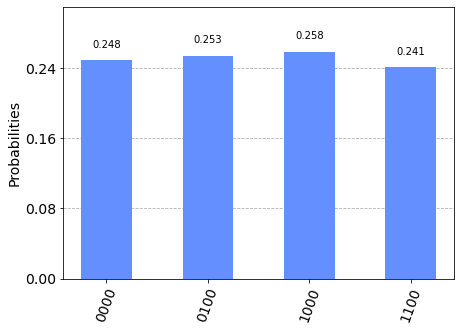

In [4]:
aersim = Aer.get_backend('aer_simulator')
tqc = transpile(qc,aersim)
results = aersim.run(tqc,shots=5000).result()
plot_histogram(results.get_counts())

In [8]:
checkedlist = []
factorfound = False
for output in results.get_counts():
    if results.get_counts()[output] > 30: #filtering any measurements from random noise
        phase = int(output,base=2)/(2**nbits)
        r = Fraction(phase).limit_denominator(int(N/2)).denominator
        if r not in checkedlist:
            checkedlist.append(r)
            if r > 1 and r % 2 == 0:
                if int(numa**(r/2)) <= 2**62: #gcd requires numbers below 2^64
                    p1 = np.gcd(int(numa**(r/2)-1),N)
                    p2 = np.gcd(int(numa**(r/2)+1),N)
                    plist = [p1,p2] if p1 <= p2 else [p2,p1]
                    if p1 * p2 == N and p1 != 1 and p2 != 1:
                        print( f"{plist[0]:<2d}* {plist[1]:<3d} = {N:<3d}, r = {r:<3d}, a = {numa:<3d}, nbits = {nbits:<2d}")
                        factorfound = True
if not factorfound:
    print(f"{N} is prime or cannot be found with a = {numa}")

3 * 5   = 15 , r = 4  , a = 2  , nbits = 4 


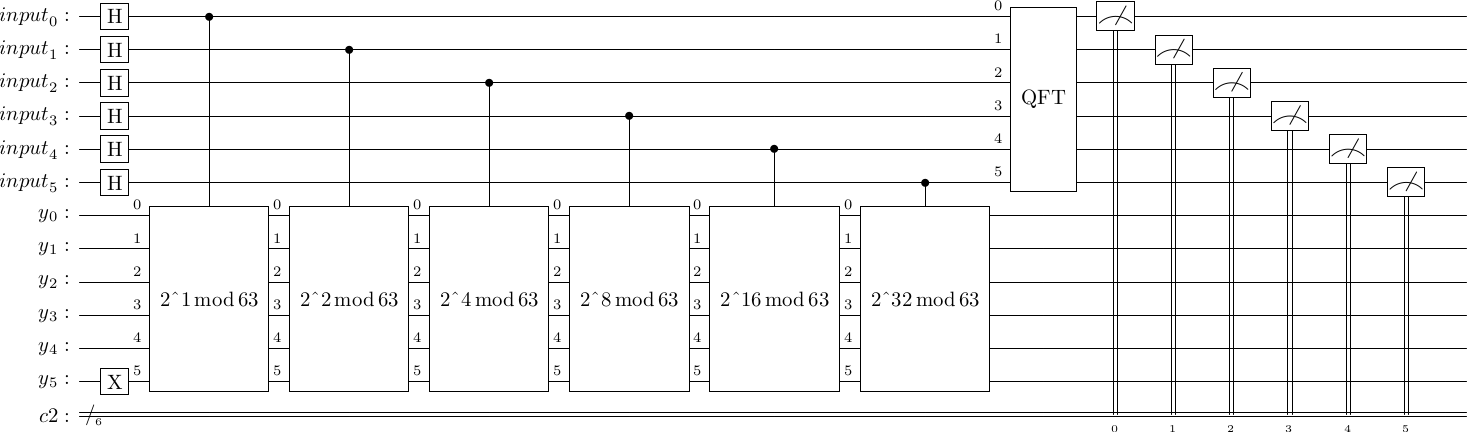

In [13]:
#Altenative gate construction for x = 2 and N = 2^n - 1
power2 = 6
N = 2**power2 - 1

def powermodp2(power,power2): #multiply by 2^p (mod 2^n-1)
    U = QuantumCircuit(power2)
    for i in range(power):
        for j in range(power2-1):
            U.swap(j,j+1)
    U = U.to_gate()
    U.name = f"2^{power} mod {N}"
    c_U = U.control()
    return c_U

nbits = power2 #edit this line to change the size of the input regiter (eg: nbits = power2 - 1)
xreg = QuantumRegister(nbits,"input")
y = QuantumRegister(power2,"y")
cx = ClassicalRegister(nbits)
qc = QuantumCircuit(xreg,y,cx)
qc.h(xreg[:])
qc.x(nbits + power2 - 1)
for k in range(nbits):
    qc.append(powermodp2(2**k,power2),[k] + y[:])

qc.append(QFT(nbits),range(nbits))
qc.measure(range(nbits),range(nbits))

qc.draw(fold=-1,output="latex")
